<a href="https://colab.research.google.com/github/dorobat-diana/LicentaAi/blob/main/MobileNetV2_FamousPlaces_Phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check for cuda

In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: True
GPU Name: Tesla T4


In [ ]:
import tensorflow as tf

tf.config.experimental_run_functions_eagerly(True)

print("Eager execution enabled:", tf.executing_eagerly())


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Eager execution enabled: True


Load previously trained model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = '/content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/fine_tuned_model.h5'
model = load_model(model_path)

Locate and unfreeze last N layers of MobileNetV2

In [ ]:
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and 'mobilenetv2' in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    raise ValueError("Could not find MobileNetV2 base model in the loaded model.")

Unfreeze more layers (e.g., last 10 layers)

In [ ]:
N = 10
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False

Set up ImageDataGenerator with validation split

In [ ]:
img_size = (224, 224)
batch_size = 32

train_dir = '/content/drive/MyDrive/ColabNotebooks/data/famous_places/split/train'
test_dir = '/content/drive/MyDrive/ColabNotebooks/data/famous_places/split/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3050 images belonging to 50 classes.
Found 3050 images belonging to 50 classes.


In [ ]:
import json

index_to_class = {v: k for k, v in train_generator.class_indices.items()}

with open('class_mapping.json', 'w') as f:
    json.dump(index_to_class, f)


Set up callbacks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/phase3_fine_tuned_model.keras',
    monitor='val_loss',
    save_best_only=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

Train the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    verbose=2
)

val_loss, val_accuracy = model.evaluate(val_generator)
print(f" Phase 3 complete — Validation accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/30
96/96 - 2497s - 26s/step - accuracy: 0.5895 - loss: 1.5185 - val_accuracy: 0.2108 - val_loss: 10.0310 - learning_rate: 1.0000e-03
Epoch 2/30
96/96 - 132s - 1s/step - accuracy: 0.7118 - loss: 1.0465 - val_accuracy: 0.1744 - val_loss: 13.6881 - learning_rate: 1.0000e-03
Epoch 3/30
96/96 - 131s - 1s/step - accuracy: 0.7452 - loss: 0.9054 - val_accuracy: 0.2207 - val_loss: 11.6407 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 - 142s - 1s/step - accuracy: 0.7957 - loss: 0.7248 - val_accuracy: 0.1564 - val_loss: 15.4954 - learning_rate: 1.0000e-03
Epoch 5/30
96/96 - 131s - 1s/step - accuracy: 0.8495 - loss: 0.4956 - val_accuracy: 0.2102 - val_loss: 12.7081 - learning_rate: 5.0000e-04
Epoch 6/30
96/96 - 165s - 2s/step - accuracy: 0.8803 - loss: 0.4004 - val_accuracy: 0.1410 - val_loss: 15.8829 - learning_rate: 5.0000e-04
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

We can observe overfitting above so we are trying another approach.

Changes included:

Added a Dropout layer (after the base model).

Applied L2 regularization to the Dense layers.

Changed early stopping patience to 5.

In [ ]:
from tensorflow.keras import layers, models, regularizers

N = 10
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False

l2_strength = 0.001
dropout_rate = 0.3

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/phase3_with_dropout_l2.keras',
    monitor='val_loss',
    save_best_only=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    verbose=2
)

val_loss, val_accuracy = model.evaluate(val_generator)
print(f" New fine-tuning complete — Validation accuracy: {val_accuracy * 100:.2f}%")


Found 3050 images belonging to 50 classes.
Found 3050 images belonging to 50 classes.
Epoch 1/30
96/96 - 107s - 1s/step - accuracy: 0.5679 - loss: 2.1122 - val_accuracy: 0.5282 - val_loss: 3.5073 - learning_rate: 1.0000e-03
Epoch 2/30
96/96 - 103s - 1s/step - accuracy: 0.7761 - loss: 1.2021 - val_accuracy: 0.4452 - val_loss: 4.6757 - learning_rate: 1.0000e-03
Epoch 3/30
96/96 - 103s - 1s/step - accuracy: 0.8148 - loss: 1.0391 - val_accuracy: 0.6030 - val_loss: 2.9444 - learning_rate: 1.0000e-03
Epoch 4/30
96/96 - 102s - 1s/step - accuracy: 0.8393 - loss: 0.9425 - val_accuracy: 0.5954 - val_loss: 3.3652 - learning_rate: 1.0000e-03
Epoch 5/30
96/96 - 153s - 2s/step - accuracy: 0.8511 - loss: 0.8825 - val_accuracy: 0.5603 - val_loss: 3.8161 - learning_rate: 1.0000e-03
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
96/96 - 130s - 1s/step - accuracy: 0.8639 - loss: 0.8408 - val_accuracy: 0.5577 - val_loss: 3.8395 - learning_rate: 1.0000e-03
Epoch 7/3

Testing the performance

96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step


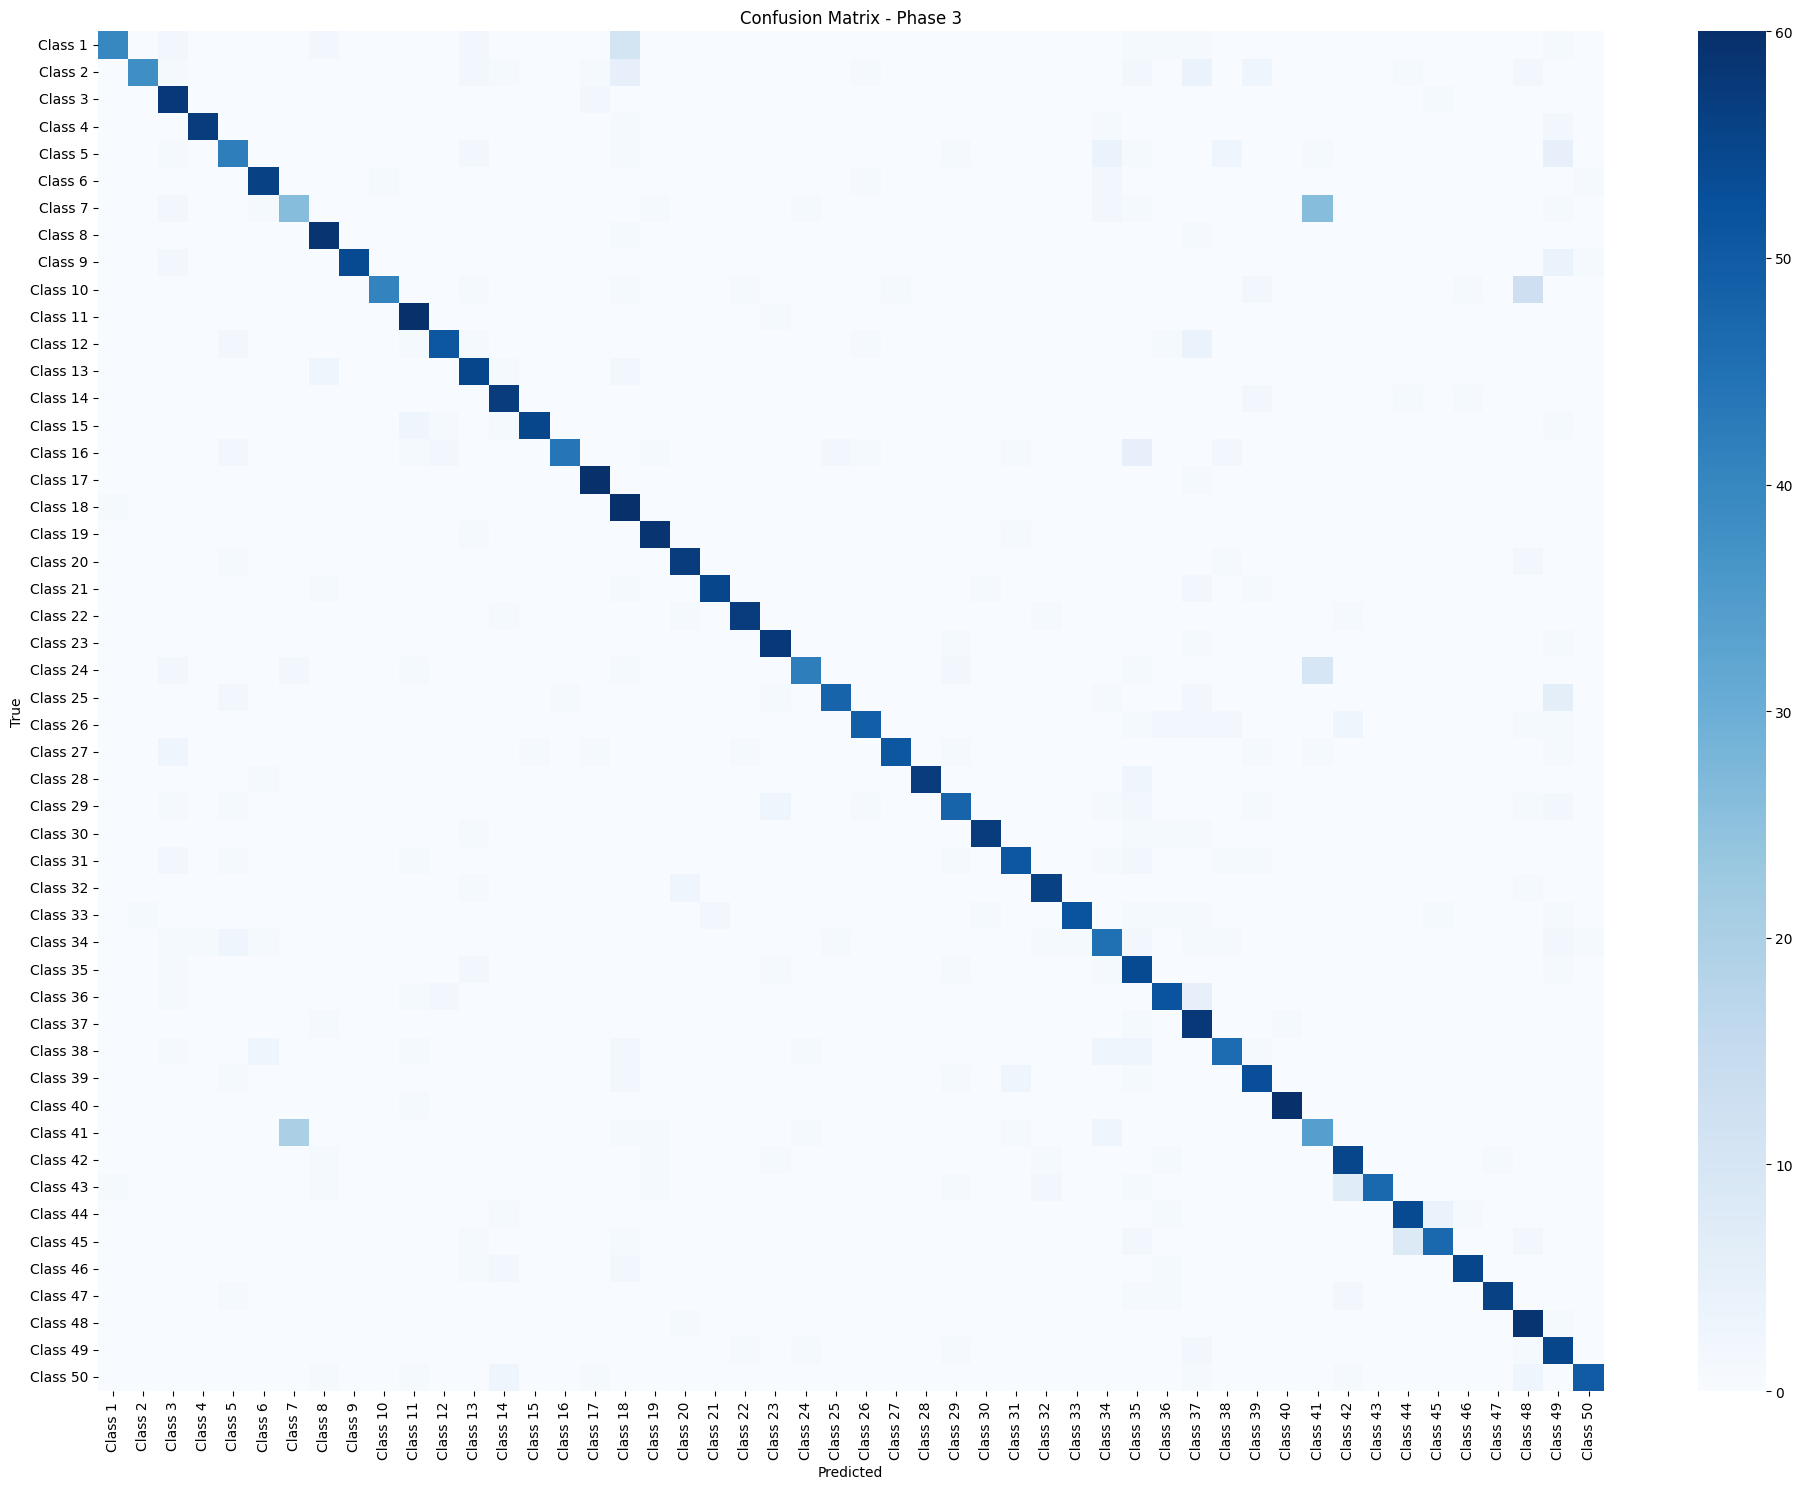

Saved confusion matrix to: /content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/report_assets/confusion_matrix_phase3.csv
Saved heatmap plot to: /content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/report_assets/confusion_matrix_phase3.png
Saved classification report to: /content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/report_assets/classification_report_phase3.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

output_dir = '/content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/report_assets'
os.makedirs(output_dir, exist_ok=True)

y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns=[f'Class {i}' for i in range(1, 51)],
                     index=[f'Class {i}' for i in range(1, 51)])

confusion_matrix_path = os.path.join(output_dir, 'confusion_matrix_phase3.csv')
cm_df.to_csv(confusion_matrix_path)

plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Phase 3")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt_path = os.path.join(output_dir, 'confusion_matrix_phase3.png')
plt.savefig(plt_path)
plt.show()

report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(1, 51)], output_dict=True)
report_df = pd.DataFrame(report).transpose()

classification_report_path = os.path.join(output_dir, 'classification_report_phase3.csv')
report_df.to_csv(classification_report_path)

print(f"Saved confusion matrix to: {confusion_matrix_path}")
print(f"Saved heatmap plot to: {plt_path}")
print(f"Saved classification report to: {classification_report_path}")


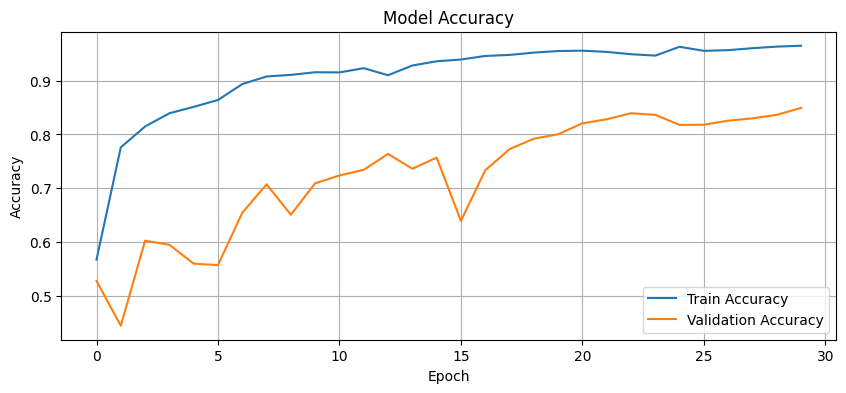

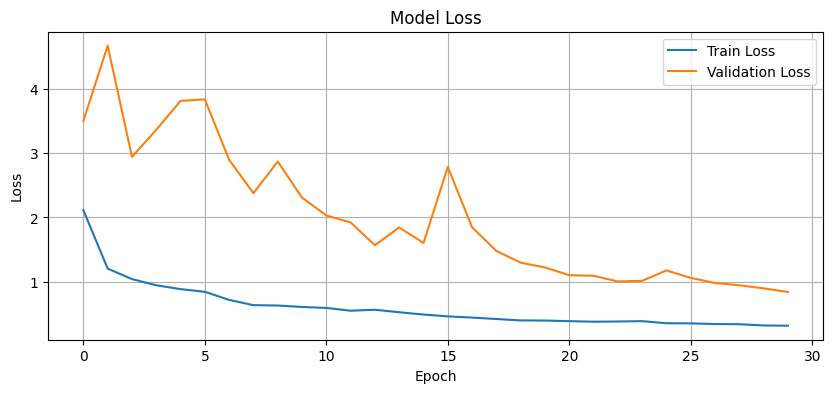

In [ ]:
import matplotlib.pyplot as plt
import os

save_path = "/content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/report_assets"
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f"{save_path}/accuracy_curve_phase3.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig(f"{save_path}/loss_curve_phase3.png")
plt.show()
